# Sprint 4

## Summary
In this final notebook, we applied the full pipeline to predict the Plant Functional Type (PFT), genus, and species of ecosystems using TLS-derived features. We joined TLS data with field-labeled inventories and built machine learning models to classify tree types. These predictions allow us to simulate vegetation composition in forests where only sensor data is available. The resulting labeled treelists provide a foundational input for physics-based wildfire models like QUIC-Fire, which require accurate representations of forest structure to simulate fire behavior.

In [24]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

The most important datasets are the TLS generated treelists and the field collected treelists. These datasets contain information about trees in different ecosystems. We also loaded in a few other datasets that helped map these two treelists together so that we could have all of the necessary information in one place.

In [25]:
# load in data
plot_inventory = pd.read_csv("data/01_plot_identification.csv")
tls_treelist = pd.read_csv("data/TLS_treelist.csv")
field_treelist = pd.read_csv("data/03_tree.csv")
pft_ref = pd.read_csv("data/FIATreeSpeciesCode_pft.csv")
fia_ref_species_table = pd.read_csv('data/REF_SPECIES.csv')

In [26]:
pft_full = pft_ref.merge(fia_ref_species_table[['COMMON_NAME', 'GENUS', 'SPECIES']], on = 'COMMON_NAME')

In [27]:
# add in PFT labels to field treelist
field_pft = field_treelist.merge(pft_full, left_on = 'tree_sp_scientific_name', right_on = 'SCI_NAME')
field_pft.head()

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,tree_burn,tree_ht,tree_htlcb,tree_resprouting,tree_decay_class,tree_decay_class_label,treepost_scorch_m,treepost_scorch_per,treepost_torch_m,treepost_torch_per,treepost_bole_char_m,tree_notes,SPCD,COMMON_NAME,SCI_NAME,SPGRPCD.E,SPGRPCD.W,MAJGRP,OCC.NC,OCC.NE,OCC.PNW,OCC.RM,OCC.SO,PFT,GENUS,SPECIES
0,143_pre_SHA_burn3d,6,209,CADE,Calocedrus decurrens,NaN,Live,Live,70.7,NaN,False,19.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,incense-cedar,Calocedrus decurrens,9,20,2,-,-,X,X,-,Evergreen conifer,Calocedrus,decurrens
1,143_pre_SHA_burn3d,11,B,CADE,Calocedrus decurrens,NaN,Dead,Dead,29.7,NaN,False,3.0,NaN,NaN,2.0,"2. Few limbs, no fine brances. Top bronken. Pe...",NaN,NaN,NaN,NaN,NaN,NaN,81,incense-cedar,Calocedrus decurrens,9,20,2,-,-,X,X,-,Evergreen conifer,Calocedrus,decurrens
2,140_pre_SHA_burn3d,7,92,CADE,Calocedrus decurrens,NaN,Live,Live,10.2,NaN,False,5.0,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,incense-cedar,Calocedrus decurrens,9,20,2,-,-,X,X,-,Evergreen conifer,Calocedrus,decurrens
3,140_pre_SHA_burn3d,8,93,CADE,Calocedrus decurrens,NaN,Live,Live,10.6,NaN,False,5.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,incense-cedar,Calocedrus decurrens,9,20,2,-,-,X,X,-,Evergreen conifer,Calocedrus,decurrens
4,140_pre_SHA_burn3d,9,94,CADE,Calocedrus decurrens,NaN,Live,Live,9.4,NaN,False,4.0,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,incense-cedar,Calocedrus decurrens,9,20,2,-,-,X,X,-,Evergreen conifer,Calocedrus,decurrens


Below, we add in the field collected PFT, Genus, and Species labels to the TLS dataset. This will make up the "training data" for our modeling process, as we need to have some sort of known values of PFT, Genus, and Species so we can train a model to detect those patterns. It is worth noting that we lose quite a lot of data in this process, as of the 1,382 observations in the original TLS dataset, only 275 of them had a corresponding field collected entry.

In [28]:
# add in PFT, GENUS, SPECIES labels to TLS treelist
tls_full = (tls_treelist.merge(plot_inventory[['plot_blk', 'inventory_id']], on='plot_blk', how='inner')
.merge(field_pft[['PFT', 'GENUS', 'SPECIES', 'inventory_id', 'tree_id']],
       left_on = ['inventory_id','TreeID'], right_on = ['inventory_id','tree_id'], how = 'inner'))
tls_full

,Unnamed: 0,TreeID,X,Y,Radius,Error,H,h_radius,DBH,BasalA,plot_blk,inventory_id,PFT,GENUS,SPECIES,tree_id
0,0,1,10.673382,2.127033,0.266540,0.001199,12.560,1.3,20.987379,2.402324,CAFKU_0101_20240802_1,101_pre_SHA_burn3d,Evergreen conifer,Calocedrus,decurrens,1
1,3,6,2.429448,1.055521,0.166444,0.000730,8.742,1.3,13.105771,0.936786,CAFKU_0101_20240802_1,101_pre_SHA_burn3d,Evergreen conifer,Calocedrus,decurrens,6
2,5,9,1.962382,8.781092,0.267219,0.001217,18.144,1.3,21.040854,2.414582,CAFKU_0101_20240802_1,101_pre_SHA_burn3d,Evergreen conifer,Calocedrus,decurrens,9
3,6,12,1.433234,0.234223,0.208154,0.000543,13.790,1.3,16.390056,1.465130,CAFKU_0101_20240802_1,101_pre_SHA_burn3d,Evergreen conifer,Calocedrus,decurrens,12
4,0,3,3.842913,-2.520822,0.335033,0.000143,21.171,1.3,26.380520,3.795612,CATNF_6043_20240814_1,43_pre_ind_burn3d,Evergreen conifer,Pinus,jeffreyi,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0,2,3.082390,7.990143,0.214055,0.000274,21.358,1.3,16.854690,1.549375,CATNF_6054_20240813_1,54_pre_ind_burn3d,Evergreen conifer,Abies,magnifica,2
271,3,5,2.101583,-6.279878,0.302285,0.000256,11.471,1.3,23.801953,3.089871,CATNF_6054_20240813_1,54_pre_ind_burn3d,Evergreen conifer,Abies,magnifica,5
272,4,6,1.764563,10.601396,0.182523,0.005669,22.188,1.3,14.371822,1.126520,CATNF_6054_20240813_1,54_pre_ind_burn3d,Evergreen conifer,Abies,magnifica,6
273,5,8,-0.549767,5.750922,0.047607,0.000821,21.001,1.3,3.748549,0.076638,CATNF_6054_20240813_1,54_pre_ind_burn3d,Evergreen conifer,Abies,magnifica,8


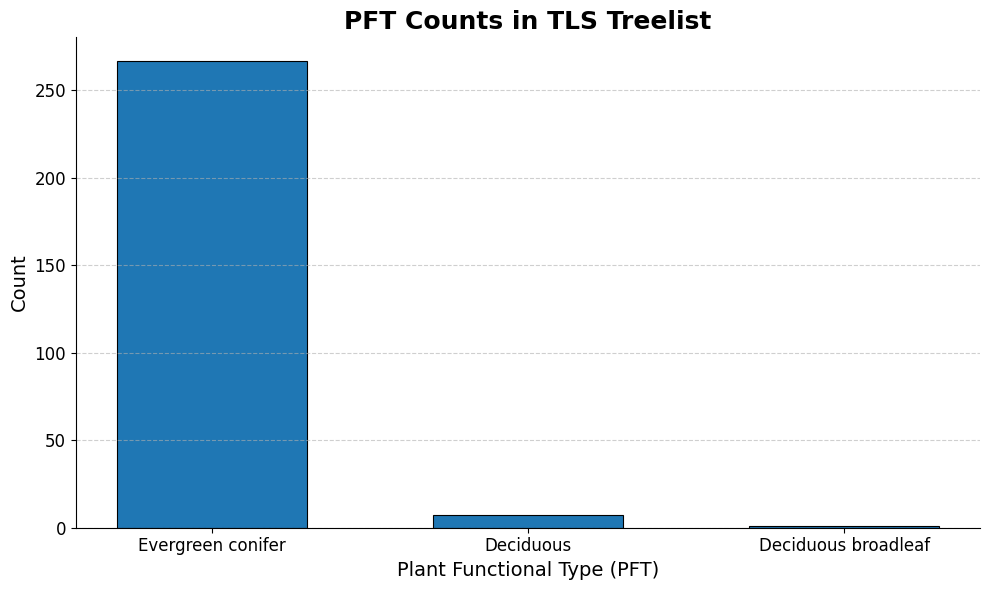

In [29]:
pft_counts = tls_full['PFT'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(pft_counts.index, pft_counts.values, width=0.6)

for bar in bars:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.8)

ax.set_title('PFT Counts in TLS Treelist', fontsize=18, weight='bold')
ax.set_xlabel('Plant Functional Type (PFT)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax.grid(axis='y', linestyle='--', alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


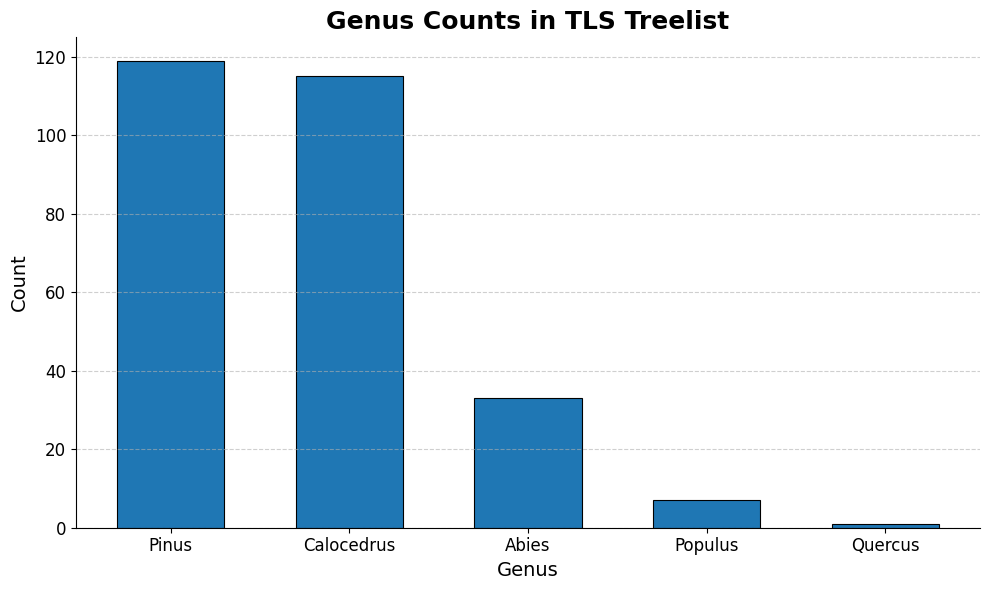

In [30]:
genus_counts = tls_full['GENUS'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(genus_counts.index, genus_counts.values, width=0.6)

for bar in bars:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.8)

ax.set_title('Genus Counts in TLS Treelist', fontsize=18, weight='bold')
ax.set_xlabel('Genus', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax.grid(axis='y', linestyle='--', alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


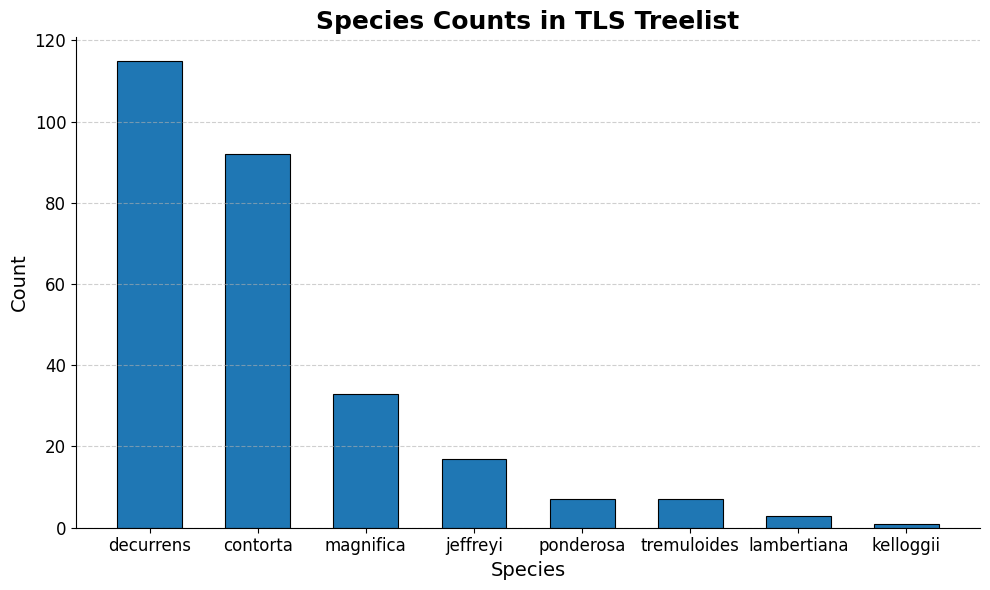

In [31]:
species_counts = tls_full['SPECIES'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(species_counts.index, species_counts.values, width=0.6)

for bar in bars:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.8)

ax.set_title('Species Counts in TLS Treelist', fontsize=18, weight='bold')
ax.set_xlabel('Species', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax.grid(axis='y', linestyle='--', alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


The above three graphs show the distribution of our 3 variables of interest in the training data. We can see that modeling PFT could become problematic because the overwhelming majority of the entries are "Evergreen conifer", so models will be privy to overfit. We plan on using oversampling to try and address this issue. The distributions are better spread out in the other two variables.

In [32]:
# add a feature modeling crown volume as a cylinder
tls_full['crown_volume'] = tls_full['Radius'] ** 2 * tls_full['H']

features = ['DBH', 'Radius', 'H', 'BasalA', 'crown_volume']

We will use 5 numeric features to try and predict PFT, Genus, and Species — a tree's diameter, radius, height, basal area, and crown volume.

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

# Step 1: Define features and target
X = tls_full[features]
y_pft = tls_full['PFT']

# Drop rare PFTs with <2 instances so we can stratify
pft_counts = y_pft.value_counts()
valid_pfts = pft_counts[pft_counts >= 2].index
filtered_data = tls_full[tls_full['PFT'].isin(valid_pfts)]

X = filtered_data[features]
y_pft = filtered_data['PFT']

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_pft, test_size=0.2, stratify=y_pft, random_state=12
)

# Apply oversampling to training data to balance classes 
ros = RandomOverSampler(random_state=12)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the model
pft_model = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=12)
pft_model.fit(X_train_resampled, y_train_resampled)

#  Evaluate on test set
pft_preds = pft_model.predict(X_test)
print(classification_report(y_test, pft_preds))


                   precision    recall  f1-score   support

        Deciduous       0.00      0.00      0.00         1
Evergreen conifer       0.98      1.00      0.99        54

         accuracy                           0.98        55
        macro avg       0.49      0.50      0.50        55
     weighted avg       0.96      0.98      0.97        55



/Users/pranavrajaram/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranavrajaram/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranavrajaram/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

We can see that the model had an f1-score of 96%, which is promising but obviously a bit skewed because almost all of the entries were Evergreen conifers.

In [34]:
# filter TLS to just have the TLS trees that do not have PFT labels
tls_only = tls_treelist[tls_treelist['plot_blk'].isin(tls_full['plot_blk']) == False]
tls_only['crown_volume'] = tls_only['Radius'] ** 2 * tls_only['H']
tls_only.shape


(850, 12)

Since we now have a model that can predict PFT, we can apply it more "unseen" data. Specifically, we can take all of the TLS observations that did *not* have a corresponding field data entry, and try to predict their PFTs. 

In [35]:
# predict PFT for unseen TLS trees
X_tls = tls_only[features]
tls_only['predicted_pft'] = pft_model.predict(X_tls)

tls_only['predicted_pft'].value_counts()

predicted_pft
Evergreen conifer    845
Deciduous              5
Name: count, dtype: int64

It looks like the oversampling process was successful, as the model predicts 12 Deciduous compared to 0 when there was no oversampling. These results are still far from perfect as the field training data was not very representative, but the model still is capable of distinguishing between Evergreen conifers and Deciduous trees,

Now, let's apply a similar modeling process to try and predict Genus and Species.

In [ ]:
# Genus prediction

# Feature matrix and target
X_genus = tls_full[features]
y_genus = tls_full['GENUS']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_genus, y_genus, test_size=0.2, random_state=12)

# Train model
genus_model = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=12)
genus_model.fit(X_train, y_train)

# Evaluate
y_pred_genus = genus_model.predict(X_test)
print("Classification Report - GENUS:\n")
print(classification_report(y_test, y_pred_genus))

# Predict for TLS-only trees
tls_only['predicted_genus'] = genus_model.predict(tls_only[features])

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/pranavrajaram/Library/Python/3.10/lib/python/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Classification Report - GENUS (Tuned):

              precision    recall  f1-score   support

       Abies       0.00      0.00      0.00         9
  Calocedrus       0.58      0.50      0.54        22
       Pinus       0.43      0.59      0.50        22
     Populus       0.00      0.00      0.00         2

    accuracy                           0.44        55
   macro avg       0.25      0.27      0.26        55
weighted avg       0.40      0.44      0.41        55



In [37]:
valid_species = species_counts[species_counts >= 2].index
filtered_data_species = tls_full[tls_full['SPECIES'].isin(valid_species)]

# Feature matrix and target
X_species = filtered_data_species[features]
y_species = filtered_data_species['SPECIES']

X_train, X_test, y_train, y_test = train_test_split(
    X_species, y_species, test_size=0.2, stratify=y_species, random_state=12
)

# Train model
species_model = RandomForestClassifier(n_estimators=20, class_weight='balanced', random_state=12)
species_model.fit(X_train, y_train)

# Evaluate
y_pred_species = species_model.predict(X_test)
print(classification_report(y_test, y_pred_species))

# Predict for TLS-only trees
tls_only['predicted_species'] = species_model.predict(tls_only[features])


              precision    recall  f1-score   support

    contorta       0.55      0.58      0.56        19
   decurrens       0.54      0.65      0.59        23
    jeffreyi       0.00      0.00      0.00         3
 lambertiana       0.00      0.00      0.00         1
   magnifica       0.00      0.00      0.00         7
   ponderosa       0.00      0.00      0.00         1
 tremuloides       0.00      0.00      0.00         1

    accuracy                           0.47        55
   macro avg       0.16      0.18      0.16        55
weighted avg       0.41      0.47      0.44        55



/Users/pranavrajaram/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranavrajaram/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pranavrajaram/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

The models for Genus and Species had mixed results, with roughly a 50% F1 score. This is a decent starting point and shows that there certainly are trends that indicate a certain Genus or Species.

Below, we show the most common combination of PFT, Genus, and Species in the TLS dataset according to the model.

In [38]:
tls_only[['predicted_pft', 'predicted_genus', 'predicted_species']].value_counts()

predicted_pft      predicted_genus  predicted_species
Evergreen conifer  Calocedrus       decurrens            323
                   Pinus            contorta             199
                                    decurrens            141
                   Calocedrus       contorta              46
                                    magnifica             29
                   Pinus            jeffreyi              28
                                    magnifica             18
                   Abies            magnifica             15
                                    decurrens             10
                   Pinus            ponderosa             10
                                    lambertiana            6
                                    tremuloides            5
                   Calocedrus       ponderosa              4
                   Populus          contorta               4
                   Calocedrus       tremuloides            2
Deciduous          Pinus       

In [39]:
# Aggregate pft predictions per plot

pft_plot_dist = tls_only.groupby(['plot_blk', 'predicted_pft']).size().reset_index(name='count')
pft_plot_dist['pct'] = pft_plot_dist.groupby('plot_blk')['count'].transform(lambda x: 100 * x / x.sum())

# Aggregate genus predictions per plot
genus_plot_dist = tls_only.groupby(['plot_blk', 'predicted_genus']).size().reset_index(name='count')
genus_plot_dist['pct'] = genus_plot_dist.groupby('plot_blk')['count'].transform(lambda x: 100 * x / x.sum())

# Aggregate species predictions per plot
species_plot_dist = tls_only.groupby(['plot_blk', 'predicted_species']).size().reset_index(name='count')
species_plot_dist['pct'] = species_plot_dist.groupby('plot_blk')['count'].transform(lambda x: 100 * x / x.sum())

In [40]:
pft_by_plot = pft_plot_dist.pivot_table(
    index='plot_blk',
    columns='predicted_pft',
    values='pct',
    fill_value=0
)
pft_by_plot

predicted_pft,Deciduous,Evergreen conifer
plot_blk,,
CAFKU_0096_20240804_1,0.000000,100.000000
CAFKU_0100_20240804_1,0.000000,100.000000
CALNU_0028_20241110_1,5.263158,94.736842
CALNU_0029_20241110_1,0.000000,100.000000
CALNU_0030_20241110_1,0.000000,100.000000
...,...,...
CATCU_0123_20241013_1,0.000000,100.000000
CATCU_0125_20241013_1,0.000000,100.000000
CATNF_6046_20240817_1,0.000000,100.000000


In [41]:
genus_by_plot = genus_plot_dist.pivot_table(
    index='plot_blk',
    columns='predicted_genus',
    values='pct',
    fill_value=0
)
genus_by_plot

predicted_genus,Abies,Calocedrus,Pinus,Populus,Quercus
plot_blk,,,,,
CAFKU_0096_20240804_1,0.000000,0.000000,100.000000,0.0,0.0
CAFKU_0100_20240804_1,0.000000,75.000000,25.000000,0.0,0.0
CALNU_0028_20241110_1,0.000000,47.368421,52.631579,0.0,0.0
CALNU_0029_20241110_1,0.000000,72.727273,27.272727,0.0,0.0
CALNU_0030_20241110_1,0.000000,40.909091,59.090909,0.0,0.0
...,...,...,...,...,...
CATCU_0123_20241013_1,0.000000,57.142857,42.857143,0.0,0.0
CATCU_0125_20241013_1,7.692308,46.153846,46.153846,0.0,0.0
CATNF_6046_20240817_1,0.000000,50.000000,50.000000,0.0,0.0


In [42]:
species_by_plot = species_plot_dist.pivot_table(
    index='plot_blk',
    columns='predicted_species',
    values='pct',
    fill_value=0
)
species_by_plot

predicted_species,contorta,decurrens,jeffreyi,lambertiana,magnifica,ponderosa,tremuloides
plot_blk,,,,,,,
CAFKU_0096_20240804_1,0.000000,100.000000,0.000000,0.000000,0.000000,0.0,0.0
CAFKU_0100_20240804_1,0.000000,100.000000,0.000000,0.000000,0.000000,0.0,0.0
CALNU_0028_20241110_1,36.842105,63.157895,0.000000,0.000000,0.000000,0.0,0.0
CALNU_0029_20241110_1,9.090909,90.909091,0.000000,0.000000,0.000000,0.0,0.0
CALNU_0030_20241110_1,31.818182,63.636364,4.545455,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
CATCU_0123_20241013_1,42.857143,42.857143,0.000000,0.000000,14.285714,0.0,0.0
CATCU_0125_20241013_1,0.000000,92.307692,0.000000,7.692308,0.000000,0.0,0.0
CATNF_6046_20240817_1,50.000000,50.000000,0.000000,0.000000,0.000000,0.0,0.0


The above three tables show the PFT, Genus, and Species distribution for each plot in the TLS dataset, answering our main research question. In order to facilitate further exploration, we also created a small interactive tool that allows you to more easily work with the 112 different plots that we have access to. You can use the tool here:

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

plot_blks = sorted(pft_by_plot.index)

def plot_pie_charts(plot_blk):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot PFT Pie
    pft_row = pft_by_plot.loc[plot_blk]
    pft_row[pft_row > 0].plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=90)
    axes[0].set_title(f"PFT Distribution - {plot_blk}")
    axes[0].set_ylabel('')

    # Plot Genus Pie
    genus_row = genus_by_plot.loc[plot_blk]
    genus_row[genus_row > 0].plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f"Genus Distribution - {plot_blk}")
    axes[1].set_ylabel('')

    # Plot Species Pie
    species_row = species_by_plot.loc[plot_blk]
    species_row[species_row > 0].plot.pie(ax=axes[2], autopct='%1.1f%%', startangle=90)
    axes[2].set_title(f"Species Distribution - {plot_blk}")
    axes[2].set_ylabel('')

    plt.tight_layout()
    plt.show()

# Interactive dropdown
interact(plot_pie_charts, plot_blk=widgets.Dropdown(options=plot_blks, value='CATCU_0117_20241011_1', description='Plot:'));


interactive(children=(Dropdown(description='Plot:', index=101, options=('CAFKU_0096_20240804_1', 'CAFKU_0100_2…